In [2]:
%matplotlib inline
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# クラスタリング
機械学習には正解データを必要としないタイプも有る (**教師なし学習**)。分類の方法には似たデータでグルーピングする方法があり、 **クラスタリング** と呼ばれている。グループは **クラスタ** と呼び、これを求める事で一連のデータに潜む複数種類の集団を炙り出せる (ex: 顧客の行動から性別や年齢の違いなどにより異なる行動をする集団を抽出する)。ちなみに直接観測されないがデータの分布などへ影響を与える変数の事を **潜在変数** と呼ぶ。この場合、クラスタが分布を決める潜在変数になっている。

## サンプルデータ

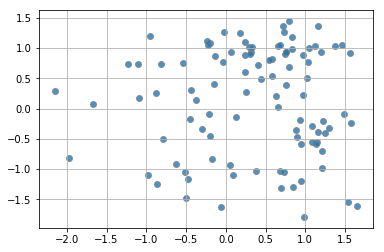

In [3]:
def get_sample_data():
    np.random.seed(seed=1)
    N, K = 100, 3

    # クラス値T生成 (3クラス分類)
    Mu = np.array([[-0.5, -0.5], [0.5, 1.0], [1.0, -0.5]])  # 分布の中心
    Sig = np.array([[0.7, 0.7], [0.8, 0.3], [0.3, 0.8]])  # 分布の分散
    Pi = np.array([0.4, 0.8, 1.0])  # (A) 各分布への割合 0.4 0.8 1
    wk = np.random.rand(N)

    T3 = np.zeros((N, 3), dtype=np.uint8)
    T2 = np.zeros((N, 2), dtype=np.uint8)
    X = np.zeros((N, 2))
    X_range0 = [-3, 3]
    X_range1 = [-3, 3]
    np.random.seed(seed=1)  # 乱数を固定
    for n in range(N):
        wk = np.random.rand()
        for k in range(K): # (B)
            if wk < Pi[k]:
                T3[n, k] = 1
                break
        for k in range(2):
            X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k] + Mu[T3[n, :] == 1, k])
    T2[:, 0] = T3[:, 0]
    T2[:, 1] = T3[:, 1] | T3[:, 2] 

    # # クラス値T生成 (3クラス分類)
    # T3 = np.zeros((N, 3), dtype=np.uint8)
    # T3[(0.0 <= wk) & (wk < 0.4),0] = 1
    # T3[(0.4 <= wk) & (wk < 0.8),1] = 1
    # T3[(0.8 <= wk) & (wk < 1.0),2] = 1

    # # クラス値T生成 (2クラス分類)
    # T2 = np.zeros((N, 2), dtype=np.uint8)
    # T2[:,0] = T3[:,0]
    # T2[:,1] = T3[:,1] | T3[:,2]

    # # クラス値Tから入力変数Xを生成
    # X_range0 = [-3, 3]
    # X_range1 = [-3, 3]
    # X = np.zeros((N, 2))
    # X[:,0] = np.sum(np.random.randn(N, 1) * Sig.T[0] * T3 + Mu.T[0] * T3, axis=1)
    # X[:,1] = np.sum(np.random.randn(N, 1) * Sig.T[1] * T3 + Mu.T[1] * T3, axis=1)
    
    return N, K, X, X_range0, X_range1

N, K, X, X_range0, X_range1 = get_sample_data()
plt.grid(True)
plt.scatter(X[:,0], X[:,1], edgecolor="gray", alpha=0.8)

# K-means
K-meansを用いると指定したクラスタ数(k)にデータを分割できる。この方法はクラスタの中心点の導出 (step1) と各データの所属クラスタの導出 (step2) を交互に繰り返し、歪み尺度 (各データから所属クラスタの中心点へのベクトル距離の合計) が最小になるパラメータを探し出す。最終的に歪み尺度が最小となるクラスタがR(1-of-K)、中心点がMuとして求まる。

$$
\begin{align}
    {\bf u}_k &= \frac{\sum_n r_{nk} {\bf x}_n}{\sum_n r_{nk}} \tag{step1} \\
    r_{nk} &=
        \begin{cases}
            1 \quad k = {\rm arg~min}_{k^{\prime}}~ |{\bf x}_n - {\bf u}_{k^{\prime}}| \\
            0 \quad (otherwise)
        \end{cases} \tag{step2} \\
\end{align}
$$

K-meansにも損失関数が存在し、次の式として **歪み尺度** が定義されている。なお、計算簡略化のためノルムに2乗している。

$$
\begin{align}
    j &= \sum_n \sum_k r_{nk} |{\bf x}_n - {\bf u}_k|^2 \\
      &= \sum_n \sum_k r_{nk} \sum_d (x_{nd} - u_{kd})^2 \\
\end{align}
$$

クラスタの中心点を決めるuの更新式は歪み尺度の微分から求まる。

$$
\begin{align}
    \frac{\partial j}{\partial u_{kd}}
      &= \sum_k \sum_d \sum_n r_{nk} (x_{nd} - u_{kd}) \\
      &= \sum_k \sum_d f_{kd} = 0 \\
    f_{kd}
      &= \sum_n r_{nk}x_{nd} - u_{kd} \sum_n r_{nk} \\
    u_{kd}
      &= \frac{\sum_n r_{nk}x_{nd}}{\sum_n r_{nk}} \\
\end{align}
$$

Text(0.5,1,'distorition')

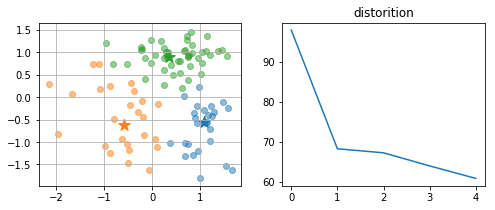

In [4]:
R = np.tile([0, 0, 1], (N, K)).astype(np.uint8)
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])

def show_kmeans(x, r, mu):
    """ クラスタリング結果を表示
    """
    plt.grid()
    for k in range(len(mu)):
        xA = x[r[:, k] == 1, 0]
        xB = x[r[:, k] == 1, 1]
        plt.scatter(xA, xB, c=f"C{k}", alpha=0.5)
        plt.scatter(*mu[k], marker="*", c=f"C{k}", s=150)

def kmeans_step1(x, r):
    """ K-means step1: クラスタ中心点を更新
    """
    # 各クラスタに属する要素数を求める
    nk = np.sum(r, axis=0)[:, np.newaxis]
    
    # x[n, 1, xy] * r[n, k, 1] -> mu[n, k, xy] -> mu[k, xy]
    mu = x[:, np.newaxis, :] * r[:, :, np.newaxis]
    mu = np.sum(mu, axis=0)
    mu = mu / nk
    return mu

def kmeans_step2(x, mu):
    """ K-means step2: 各データの各暫定クラスタ中心点へのベクトルを導出 & ノルムを出す。
    """
    # x[n, xy] - mu[k, 1, xy] -> nrm[k, n, xy] -> nrm[k, n]
    nrm = x - mu[:,np.newaxis]
    nrm = np.linalg.norm(nrm, axis=2)

    # 各データのクラスタ中心点へベクトルのノルムのうち最小のを所属クラスタとする
    k = len(mu)
    r = np.argmin(nrm, axis=0)
    r = np.array([r == idx for idx in range(k)], dtype=np.uint8)
    r = r.T
    
    # 歪み尺度を計算
    distorition = nrm.T * r
    distorition = np.sum(distorition)
        
    return r, distorition

def kmeans(x, mu):
    # クラスタ数
    k = len(mu)
    # 各データの暫定クラスを初期化
    r = np.random.randint(0, 3, N)
    r = np.array([r == idx for idx in range(k)], dtype=np.uint8)
    r = r.T

    disthist = list()
    for i in range(5):
        # step1: クラスタ中心点を更新
        mu = kmeans_step1(x, r) # [k, xy]
            
        # step2: 各データのクラス分類を更新 (歪み尺度も求める)
        r, distorition = kmeans_step2(x, mu) # [k, n]
        disthist.append(distorition)
        
    return r, mu, disthist

# k-meansでクラスタリングを行う
R, Mu, disthist = kmeans(X, Mu)

# クラスタリング結果表示
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
show_kmeans(X, R, Mu)

# 歪み尺度の推移表示
plt.subplot(1, 2, 2)
plt.plot(disthist)
plt.title("distorition")

# 確率的クラスタリング
## 混合ガウスモデル
K-meansはrが0 or 1になるが、確率を導入し0～1の間で表現する方が曖昧さを考慮できる。ここでは2次元ガウス関数を足し合わせる **混合ガウス** を分布として用いる。この場合のrは **負担率** と呼ばれる。これを **EMアルゴリズム** で解く。

$$
\begin{align}
    p(x) &= \sum_k \pi_k N({\bf x}|{\bf u}_k, \Sigma_k) \\
    \sum_k \pi_k &= 1
\end{align}
$$

In [5]:
def gauss(x, mu, sigma):
    """多次元正規分布
    
    Parameters
    ------------------
    x : np.array
        入力値
    mu : np.array
        平均値
    sigma : np.array
        共分散行列
    """
    n, d = x.shape
    
    # 前半部分 (行列式部分)
    # g: [class?, 1, 1, 1]
    g = 1 / (np.sqrt(2 * np.pi) ** d * np.sqrt(np.linalg.det(sigma)))
    g = g.reshape(*g.shape, 1, 1, 1)
    
    # 後半部分 (指数関数部分)
    # 偏差: [class?, data_n, 1(h), dimention(w)]
    devi = x - np.expand_dims(mu, -2)
    devi = np.expand_dims(devi, -1)
    
    # 共分散行列: [class?, 1, Cov(h), Cov(w)]
    sigma = np.expand_dims(sigma, -3)
    
    #   [class?, data_n,         1, dimention]
    # @ [class?,      1,    Cov(h),    Cov(w)]
    # @ [class?, data_n, dimention,         1]
    # = [class?, data_n,         1,         y]
    ex = -1 / 2 * np.swapaxes(devi, -1, -2) @ np.linalg.inv(sigma) @ devi
    ex = np.exp(ex)
    
    g = g * ex
    g = g.reshape(*g.shape[:-2])
    
    return g

x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sg = np.array([[1, 0], [0, 1]])

print(gauss(x, mu, sg))

[0.15915494 0.05854983 0.00291502]


In [6]:
def mixgauss(x, pi, mu, sigma):
    """混合ガウス関数
    
    Parameters
    ----------------------
    x: np.ndarray
        入力値
    pi: np.ndarray
        係数
    mu: np.ndarray
        クラスタ中心点
    sigma: np.ndarray
        共分散行列
    """
    return np.sum(pi[:,np.newaxis] * gauss(x, mu, sigma), axis=0)

# x: [data_n, d]
x = np.array([[1, 2], [2, 2], [3, 4]])
# mu:[class, 1, d]
mu = np.array([[[1, 1]], [[2, 2]]])
# Cov: [class, Cov(h), Cov(w)]
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]])
pi = np.array([0.3, 0.7])

mixgauss(x, pi, mu, sigma)

array([[0.05791941, 0.06531143, 0.00399105],
       [0.10913319, 0.11598962, 0.00862505]])

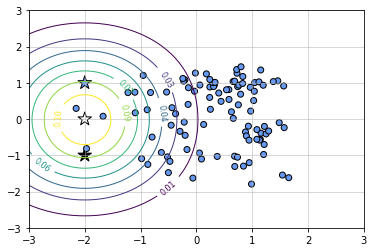

In [7]:
def show_contour_mixgauss(x, gamma, pi, mu, sigma):
    """混合ガウス可視化
    
    Parameters
    ----------------------
    x: np.ndarray
        入力値
    pi: np.ndarray
        係数
    mu: np.ndarray
        クラスタ中心点
    sigma: np.ndarray
        共分散行列
    """
    
    n, d = x.shape
    xn = 80
    x0 = np.linspace(*X_range0, xn)
    x1 = np.linspace(*X_range1, xn)
    
    xx0, xx1 = np.meshgrid(x0, x1)
    xx = np.c_[xx0.reshape(-1), xx1.reshape(-1)]
    f = mixgauss(xx, pi, mu, sigma)
    f = f.reshape(xn, xn)
    
    # 等高線
    plt.grid(linewidth=0.5)
    plt.scatter(*mu.T, s=200, marker="*", c=np.identity(3) @ ccolors, edgecolors="black")
    cont = plt.contour(xx0, xx1, f, 10, linewidths=1)
    cont.clabel(fmt="%1.2f", fontsize=8)
    
    # 散布図
    plt.scatter(*x.T, c=gamma @ ccolors, edgecolors="black")

pi = np.array([0.33, 0.33, 0.34])
mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
gamma = np.tile([1, 0, 0], (N, 1))
sigma = np.array([
    [[1, 0], [0, 1]],
    [[1, 0], [0, 1]],
    [[1, 0], [0, 1]]
])
ccolors = np.array([
    [0.4, 0.6, 0.95],
    [1.0, 1.0, 1.00],
    [0.0, 0.0, 0.00],
])

show_contour_mixgauss(X, gamma, pi, mu, sigma)

## EMアルゴリズム
混合ガウスモデルはEMアルゴリズムによってクラスタリングする。K-meansでは各クラスタは中心ベクトルuで表現したが、混合ガウスモデルではこれに加え共分散行列Σによる分布の広がりとπによる分布の大きさをパラメータとして用いる。アルゴリズムはK-meansと同じく、E Stepでγを求め (π, u, Σを用いる)、M Stepでyを使ってπ, u, Σを求める。2つのステップを誤差が収束するまで続ける。

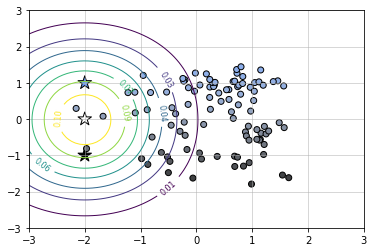

In [7]:
def e_step_mixgauss(x, pi, mu, sigma):
    n, d = x.shape
    wk = gauss(x, mu, sigma)
    wk = wk.T
    wk = pi * wk / np.sum(pi * wk, axis=1, keepdims=True)
    return wk
    
gamma = e_step_mixgauss(X, pi, mu, sigma)
show_contour_mixgauss(X, gamma, pi, mu, sigma)

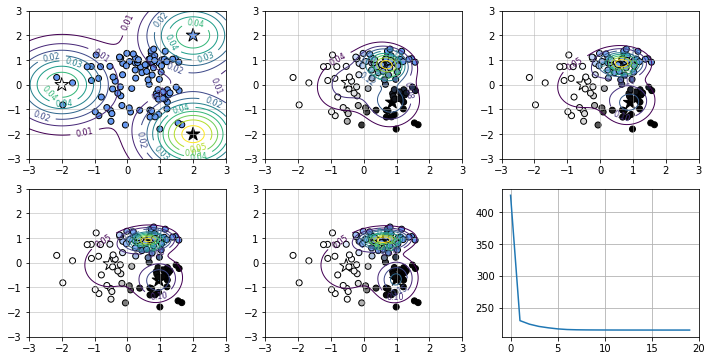

In [8]:
def m_step_mixgauss(x, gamma):
    nk = np.sum(gamma, axis=0) # [k]
    pi = nk / np.sum(nk) # [k]
    mu = np.sum(gamma[:,:,np.newaxis] * x[:,np.newaxis,:], axis=0)
    mu = mu / nk[:,np.newaxis] # [k, d]
    
    sigma = x - mu[:,np.newaxis,:] # [k, n, d]
    sigma = sigma[:,:,:,np.newaxis] # [k, n, d, 1]
    sigma = sigma @ sigma.swapaxes(-1, -2) # [k, n, d, d]
    sigma = gamma.T[:,:,np.newaxis,np.newaxis] * sigma
    sigma = np.sum(sigma, axis=1) # [k, d, d]
    sigma = sigma / nk[:,np.newaxis,np.newaxis]
    
    return pi, mu, sigma

def mixgauss_likelihood(x, pi, mu, sigma):
    y = mixgauss(x, pi, mu, sigma)
    y = np.log(y)
    y = np.sum(y)
    return -y

# 分布初期値
pi = np.array([0.3, 0.3, 0.4])
mu = np.array([[2, 2], [-2, 0], [2, -2]])
gamma = np.tile([1, 0, 0], (N, 1))
sigma = np.array([
    [[1, 0], [0, 1]],
    [[1, 0], [0, 1]],
    [[1, 0], [0, 1]]
])

# 分布推移
plt.figure(figsize=(12, 6))
likelihood = list()
for i in range(20):
    if i < 5:
        plt.subplot(2, 3, i + 1)
        show_contour_mixgauss(X, gamma, pi, mu, sigma)
        
    gamma = e_step_mixgauss(X, pi, mu, sigma)
    likelihood.append(mixgauss_likelihood(X, pi, mu, sigma))
    pi, mu, sigma = m_step_mixgauss(X, gamma)

# 尤度
plt.subplot(2, 3, 6)
plt.plot(likelihood)
plt.grid()